<a href="https://colab.research.google.com/github/petebusey/20019-20_Pistons_Salaries_csv/blob/master/Roberts_week_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [151]:
import tensorflow as tf
print(tf.__version__)

2.4.1


The Task for the AI
Our goal is to construct and train an artificial neural network on thousands of images of handwritten digits so that it may successfully identify others when presented. The data that will be incorporated is the MNIST database which contains 60,000 images for training and 10,000 test images. We will use the Keras Python API with TensorFlow as the backend.

In [152]:
from tensorflow.python.client import device_lib

In [153]:
print(device_lib.list_local_devices)

<function list_local_devices at 0x7f5ad46c8950>


Prerequisite Python Modules
First, some software needs to be loaded into the Python environment.

In [154]:

import numpy as np
import pandas as pd
import os
import random
import time
import datetime

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt



In [155]:
import os, numpy as np, pandas, csv, matplotlib.pyplot as plt
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.model_selection import RandomizedSearchCV as srch
from sklearn.metrics import f1_score as fl

In [156]:
import numpy as np                   # advanced math library
import matplotlib.pyplot as plt      # MATLAB like plotting routines
import random                        # for generating random numbers

from keras.datasets import mnist     # MNIST dataset is included in Keras
from keras.models import Sequential  # Model type to be used

from keras.layers.core import Dense, Dropout, Activation # Types of layers to be used in our model
from keras.utils import np_utils                         # NumPy related tools

Loading Training Data
The MNIST dataset is conveniently bundled within Keras, and we can easily analyze some of its features in Python.

In [157]:
# The MNIST data is split between 60,000 28 x 28 pixel training images and 10,000 28 x 28 pixel images
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


Using matplotlib, we can plot some sample images from the training set directly into this Jupyter Notebook.

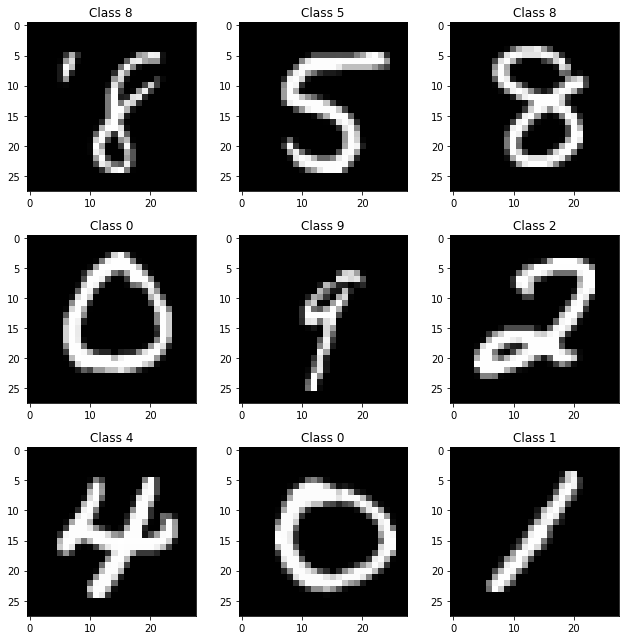

In [158]:
plt.rcParams['figure.figsize'] = (9,9) # Make the figures a bit bigger

for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(X_train))
    plt.imshow(X_train[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[num]))
    
plt.tight_layout()

Let's examine a single digit a little closer, and print out the array representing the last digit.

In [159]:
# just a little function for pretty printing a matrix
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

# now print!        
matprint(X_train[num])

0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   0  0  0  0  0  0  0  
0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   0  0  0  0  0  0  0  
0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   0  0  0  0  0  0  0  
0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   0  0  0  0  0  0  0  
0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0   17  206  236   0  0  0  0  0  0  0  
0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0   77  204  245  57  0  0  0  0  0  0  
0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0   21  211  254  243  49  0  0  0  0  0  0  
0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0   91  248  254  115   8  0  0  0  0  0  0  
0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0   18 

Each pixel is an 8-bit integer from 0-255. 0 is full black, while 255 is full white. This what we call a single-channel pixel. It's called monochrome.

Formatting the input data layer
Instead of a 28 x 28 matrix, we build our network to accept a 784-length vector.

Each image needs to be then reshaped (or flattened) into a vector. We'll also normalize the inputs to be in the range [0-1] rather than [0-255]. Normalizing inputs is generally recommended, so that any additional dimensions (for other network architectures) are of the same scale.

In [160]:
X_train = X_train.reshape(60000, 784) # reshape 60,000 28 x 28 matrices into 60,000 784-length vectors.
X_test = X_test.reshape(10000, 784)   # reshape 10,000 28 x 28 matrices into 10,000 784-length vectors.

X_train = X_train.astype('float32')   # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                        # normalize each value for each pixel for the entire vector for each input
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


We then modify our classes (unique digits) to be in the one-hot format, i.e.

0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]

1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]

2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]

etc.
If the final output of our network is very close to one of these classes, then it is most likely that class. For example, if the final output is:

[0, 0.94, 0, 0, 0, 0, 0.06, 0, 0]

then it is most probable that the image is that of the digit 1.

In [161]:
nb_classes = 10 # number of unique digits

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [162]:
# The Sequential model is a linear stack of layers and is very common.

model = Sequential()

In [163]:
# The first hidden layer is a set of 512 nodes (artificial neurons).
# Each node will receive an element from each input vector and apply some weight and bias to it.

model.add(Dense(512, input_shape=(784,))) #(784,) is not a typo -- that represents a 784 length vector!

In [164]:
# An "activation" is a non-linear function applied to the output of the layer above.
# It checks the new value of the node, and decides whether that artifical neuron has fired.
# The Rectified Linear Unit (ReLU) converts all negative inputs to nodes in the next layer to be zero.
# Those inputs are then not considered to be fired.
# Positive values of a node are unchanged.

model.add(Activation('relu'))

In [165]:
# Dropout zeroes a selection of random outputs (i.e., disables their activation)
# Dropout helps protect the model from memorizing or "overfitting" the training data.
model.add(Dropout(0.2))

In [166]:
# The second hidden layer appears identical to our first layer.
# However, instead of each of the 512-node receiving 784-inputs from the input image data,
# they receive 512 inputs from the output of the first 512-node layer.

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))

In [167]:
# The final layer of 10 neurons in fully-connected to the previous 512-node layer.
# The final layer of a FCN should be equal to the number of desired classes (10 in this case).
model.add(Dense(10))

In [168]:
# The "softmax" activation represents a probability distribution over K different possible outcomes.
# Its values are all non-negative and sum to 1.

model.add(Activation('softmax'))

In [169]:
# Summarize the built model

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 512)               401920    
_________________________________________________________________
activation_12 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               262656    
_________________________________________________________________
activation_13 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)               

Compiling the model


Keras is built on top of Theano and TensorFlow. Both packages allow you to define a computation graph in Python, which then compiles and runs efficiently on the CPU or GPU without the overhead of the Python interpreter.

When compiing a model, Keras asks you to specify your loss function and your optimizer. The loss function we'll use here is called categorical cross-entropy, and is a loss function well-suited to comparing two probability distributions.

Our predictions are probability distributions across the ten different digits (e.g. "we're 80% confident this image is a 3, 10% sure it's an 8, 5% it's a 2, etc."), and the target is a probability distribution with 100% for the correct category, and 0 for everything else. The cross-entropy is a measure of how different your predicted distribution is from the target distribution. More detail at Wikipedia

The optimizer helps determine how quickly the model learns through gradient descent. The rate at which descends a gradient is called the learning rate.

In [170]:
# Let's use the Adam optimizer for learning
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Train the model!


The batch size determines over how much data per step is used to compute the loss function, gradients, and back propagation. Large batch sizes allow the network to complete it's training faster; however, there are other factors beyond training speed to consider.

Too large of a batch size smoothes the local minima of the loss function, causing the optimizer to settle in one because it thinks it found the global minimum.

Too small of a batch size creates a very noisy loss function, and the optimizer may never find the global minimum.

So a good batch size may take some trial and error to find!

In [171]:
# model.fit(X_train, Y_train,
 #         batch_size=128, epochs=5,
 #         verbose=1)

start,myfit,end=datetime.now(),(model.fit(X_train, Y_train,batch_size=128, epochs=5,verbose=1)),datetime.now()
print("Total time to fit model:" , end-start)

Epoch 1/5
469/469 [==============================] - 2s 3ms/step - loss: 0.4424 - accuracy: 0.8679
Epoch 2/5
469/469 [==============================] - 1s 3ms/step - loss: 0.1054 - accuracy: 0.9678
Epoch 3/5
469/469 [==============================] - 1s 3ms/step - loss: 0.0722 - accuracy: 0.9771
Epoch 4/5
469/469 [==============================] - 1s 3ms/step - loss: 0.0557 - accuracy: 0.9816
Epoch 5/5
469/469 [==============================] - 1s 3ms/step - loss: 0.0445 - accuracy: 0.9853
Total time to fit model: 0:00:06.662373


The two numbers, in order, represent the value of the loss function of the network on the training set, and the overall accuracy of the network on the training data. But how does it do on data it did not train on?

Evaluating Model's accuracy on test data....

In [172]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 2ms/step - loss: 0.0633 - accuracy: 0.9823
Test score: 0.06325746327638626
Test accuracy: 0.9822999835014343



Inspecting the output
It's always a good idea to inspect the output and make sure everything looks sane. Here we'll look at some examples it gets right, and some examples it gets wrong.


In [173]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predicted_classes = model.predict_classes(X_test)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test)[0]

incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


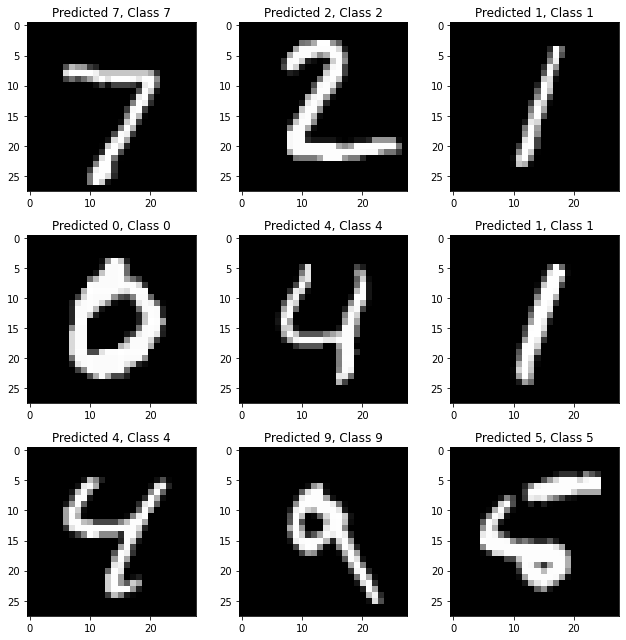

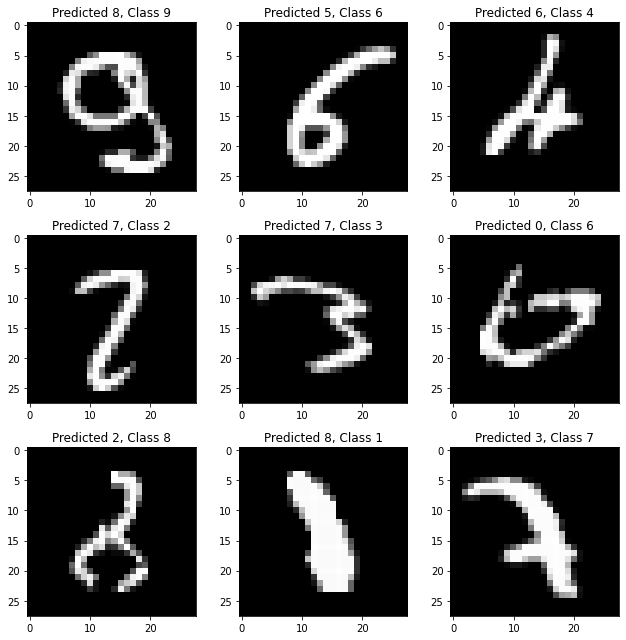

In [174]:
plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))
    
plt.tight_layout()
    
plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))
    
plt.tight_layout()

In [ ]:
# this model gives 3 layers ... first layer 512 nodes, 2nd layer 512 nodes, and third layer 10 nodes
# we can recreate just doing one layer, or 2 layers, or significantly dropping nodes per layer...
# calculate training set accuracy and test accuracy for all models yet
# calculate kaggle scores for all models yet

In [ ]:
# https://colab.research.google.com/github/AviatorMoser/keras-mnist-tutorial/blob/master/MNIST%20in%20Keras.ipynb#scrollTo=w5FteJuf1qx6